# Import

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, butter, sosfilt, sosfreqz, freqz, resample, sos2tf, tf2zpk, buttord, butter
import soundfile as sf
import pandas as pd

# ANSI S1.11 STANDARD

## Paramètres globaux

In [20]:
fs = 24000 # fréquence d'échantillonnage
bands = np.arange(22, 40)   # bande 22 → 39
Nbands = len(bands) # nombre de bandes

## Calcul des fréquences ANSI 1/3 octave

In [21]:
def ansi_band(n):
    f0 = 1000 * 2 ** ((n - 30) / 3)
    fl = f0 / 2 ** (1/6)
    fu = f0 * 2 ** (1/6)
    return fl, f0, fu

# stockage des filtres
filters_FIR = []
filters_IIR = []

## Design des filtres FIR et IIR

In [22]:
for n in bands:
    # Pour chaque bande ANSI, on calcule les fréquences de coupure et on normalise (scipy)
    fl, f0, fu = ansi_band(n)
    
    fl /= fs/2
    fu /= fs/2

    # FIR 1/3 octave (bandpass)
    taps = firwin(                 # design FIR windowed (méthode de Hamming)
        numtaps=129,               # (ordre 128)
        cutoff=[fl, fu],           # bande passante
        pass_zero=False
    )
    filters_FIR.append(taps)

    # IIR Butterworth
    sos = butter(                  # filtre IIR Butterworth d’ordre 4
        N=4,
        Wn=[fl, fu],
        btype='bandpass',
        output='sos'               # second-order sections
    )
    filters_IIR.append(sos)

print("Les 18 filtres 1/3-octave ont été générés avec succès !")

Les 18 filtres 1/3-octave ont été générés avec succès !


Juste pour rappelle :')
Un SOS d'ordre 2 (ce que l'on a) est de la forme :

$$H_i(z) = 
\frac{
b_{0,i} + b_{1,i} z^{-1} + b_{2,i} z^{-2}
}{
1 + a_{1,i} z^{-1} + a_{2,i} z^{-2}
}
$$

## Plot des réponses fréquentielles (FIR)

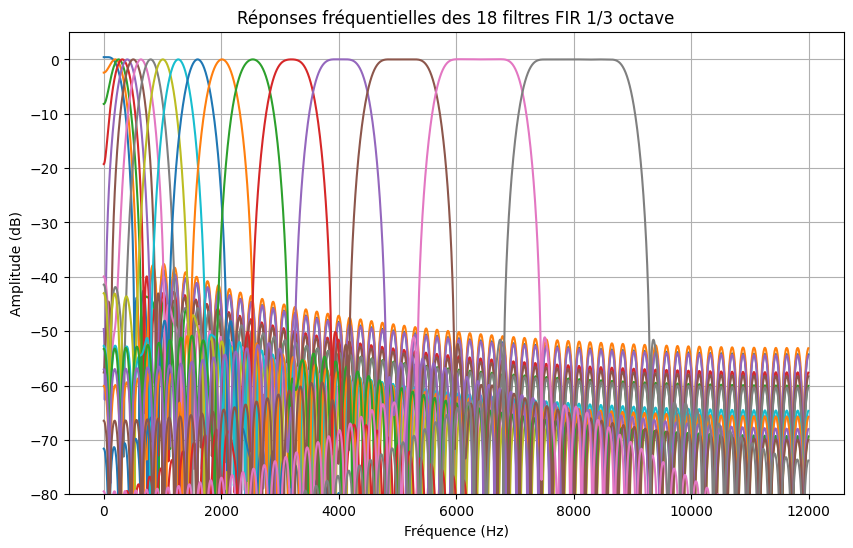

In [23]:
plt.figure(figsize=(10,6))
for taps in filters_FIR:
    # Calcul de la réponse fréquentielle complexe H(e^{jw})
    # w : vecteur de fréquences (en Hz, grâce à fs=fs)
    # h : réponse fréquentielle complexe
    w, h = freqz(taps, [1], worN=2048, fs=fs)
    plt.plot(w, 20*np.log10(np.abs(h)))

plt.title("Réponses fréquentielles des 18 filtres FIR 1/3 octave")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-80, 5])
plt.show()

## Test sur audio

In [24]:
signal, fs_in = sf.read("test.wav")

# Convertir en mono si stéréo
if signal.ndim > 1:
    signal = np.mean(signal, axis=1)

# Resample si besoin
if fs_in != fs:
    signal = resample(signal, int(len(signal) * fs / fs_in))
    print(f"Audio resamplé de {fs_in} Hz à {fs} Hz")

filtered_bands = []

#for taps in filters_FIR:
#    filtered_sig = np.convolve(signal, taps, mode='same')

for sos in filters_IIR:
    filtered_sig = sosfilt(sos, signal)
    filtered_bands.append(filtered_sig)

filtered_bands = np.array(filtered_bands).T

print("Filtrage terminé !")

Audio resamplé de 44100 Hz à 24000 Hz
Filtrage terminé !


## Sauvegarde des bandes filtrées

In [25]:
# Sauvegarde des bandes filtrées
import os
if not os.path.exists('filtered_bands'):
    os.makedirs('filtered_bands')

for i, band in enumerate(bands):
    filename = f"filtered_bands/band_{band}.wav"
    sf.write(filename, filtered_bands[:, i], fs)
    print(f"Bande {band} sauvegardée dans {filename}")

print("Toutes les bandes filtrées ont été sauvegardées !")

Bande 22 sauvegardée dans filtered_bands/band_22.wav
Bande 23 sauvegardée dans filtered_bands/band_23.wav
Bande 24 sauvegardée dans filtered_bands/band_24.wav
Bande 25 sauvegardée dans filtered_bands/band_25.wav
Bande 26 sauvegardée dans filtered_bands/band_26.wav
Bande 27 sauvegardée dans filtered_bands/band_27.wav
Bande 28 sauvegardée dans filtered_bands/band_28.wav
Bande 29 sauvegardée dans filtered_bands/band_29.wav
Bande 30 sauvegardée dans filtered_bands/band_30.wav
Bande 31 sauvegardée dans filtered_bands/band_31.wav
Bande 32 sauvegardée dans filtered_bands/band_32.wav
Bande 33 sauvegardée dans filtered_bands/band_33.wav
Bande 34 sauvegardée dans filtered_bands/band_34.wav
Bande 35 sauvegardée dans filtered_bands/band_35.wav
Bande 36 sauvegardée dans filtered_bands/band_36.wav
Bande 37 sauvegardée dans filtered_bands/band_37.wav
Bande 38 sauvegardée dans filtered_bands/band_38.wav
Bande 39 sauvegardée dans filtered_bands/band_39.wav
Toutes les bandes filtrées ont été sauvegardée

## Plot de comparaison FIR vs IIR

/tmp/ipykernel_144923/3274457603.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w2, 20*np.log10(np.abs(h2)), '--', label="IIR")


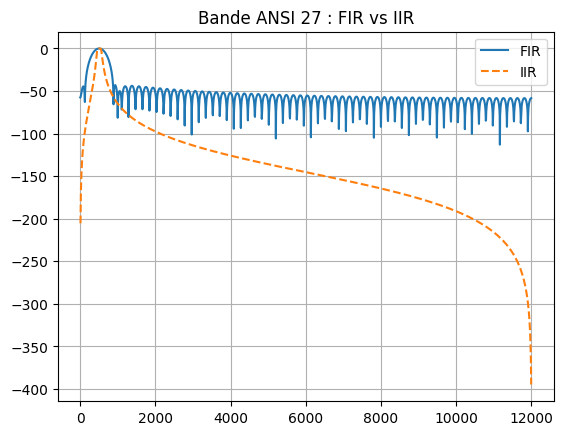

In [26]:
k = 5  # bande 27
taps = filters_FIR[k]
sos = filters_IIR[k]

# FIR
w, h = freqz(taps, [1], worN=2048, fs=fs)
plt.plot(w, 20*np.log10(np.abs(h)), label="FIR")

# IIR
w2, h2 = sosfreqz(sos, worN=2048, fs=fs)
plt.plot(w2, 20*np.log10(np.abs(h2)), '--', label="IIR")

plt.legend()
plt.grid(True)
plt.title(f"Bande ANSI {bands[k]} : FIR vs IIR")
plt.show()

In [27]:
# Tableau des ordres des filtres FIR/IIR pour chaque bande 1/3 octave
# Je ne vois pas l'intérêt de ce tableau, a ce niveau là (car ANSI S1.11 Standar) mais bon...
data = []
for i, band in enumerate(bands):
    fir_order = len(filters_FIR[i]) - 1  # ordre = taps - 1
    iir_order = 4  # Butterworth N=4
    data.append([band, fir_order, iir_order])

df = pd.DataFrame(data, columns=['Bande ANSI', 'Ordre FIR', 'Ordre IIR'])
df

,Bande ANSI,Ordre FIR,Ordre IIR
0,22,128,4
1,23,128,4
2,24,128,4
3,25,128,4
4,26,128,4
5,27,128,4
6,28,128,4
7,29,128,4
8,30,128,4
9,31,128,4


In [28]:
def quantize(coeffs, word_length, integer_bits=1, wrap=False):
    """
    Quantifie des coefficients en format virgule fixe Qm.n.
    
    Qm.n = m bits partie entière (avec signe) + n bits fractionnaire.
    Ici : Q(integer_bits).(word_length - integer_bits)
    
    Exemples:
    - quantize(coeffs, 8, 1)  -> Q1.7
    - quantize(coeffs, 16, 3) -> Q3.13
    
    Args:
        coeffs: array des coefficients (float)
        word_length: bits total (inclut bit de signe)
        integer_bits: bits partie entière (1 pour FIR, 3+ pour IIR)
        wrap : False = saturation, True = wrap-around complément a 2
    
    Returns:
        array: coefficients quantifiés (float arrondis)
    """
    
    if word_length <= integer_bits:
        raise ValueError("word_length doit être > integer_bits (inclut bit de signe).")

    # Nombre de bits fractionnaires
    frac_bits = word_length - integer_bits
    
    # Facteur d'échelle pour la partie fractionnaire
    scale = 2**frac_bits
    
    # Passage en entier fixe
    fixed = np.round(coeffs * scale)
    
    # Bornes min/max representables
    MIN = -(2 ** (integer_bits - 1))
    MAX = (2 ** (integer_bits - 1)) - (1 / scale) # ICI - (1 / scale) car c'est la plus petite valeur representable en Qm.n

    
    if wrap:
        # Wrap-around (complement a 2)
        # On ne pense pas que ce soit utile ici, saturation est préférable selon nous
        # En gros quand une valeur dépasse MAX, elle "reboucle" vers MIN et inversement
        
        # Plage totale pour un entier non signé
        range_int = 2 ** word_length
        
        # No joke regardez cette qualité de ligne, on va détailler un peu ;')
        # range_int//2 = 2^(word_length-1) : donc point milieu 
        # fixed.astype(int) convertit en entier pour l'opération modulo
        # Ici modulo est utilisé pour "reboucler" les valeurs hors bornes
        # - (range_int//2) pour soustraire le décalage initial
        fixed = ((fixed.astype(int) + range_int//2) % range_int) - (range_int//2)
    else:
        # Saturation
        # Les valeurs qui dépassent sont "écrasées" aux bornes, donc en théorie moins d'instabilités
        fixed = np.clip(fixed, MIN * scale, MAX * scale)

    return fixed / scale


/tmp/ipykernel_144923/279753076.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label='IIR quantisé')
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:482: RuntimeWarning: divide by zero encountered in divide
  h = (npp_polyval(zm1, b, tensor=False) /
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:482: RuntimeWarning: invalid value encountered in divide
  h = (npp_polyval(zm1, b, tensor=False) /
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:861: RuntimeWarning: invalid value encountered in multiply
  h *= rowh
/tmp/ipykernel_144923/279753076.py:32: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label='FIR quantisé')
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:482: RuntimeWarning: divide by zero encountered in divide
  h = (npp_polyval(zm1, b,

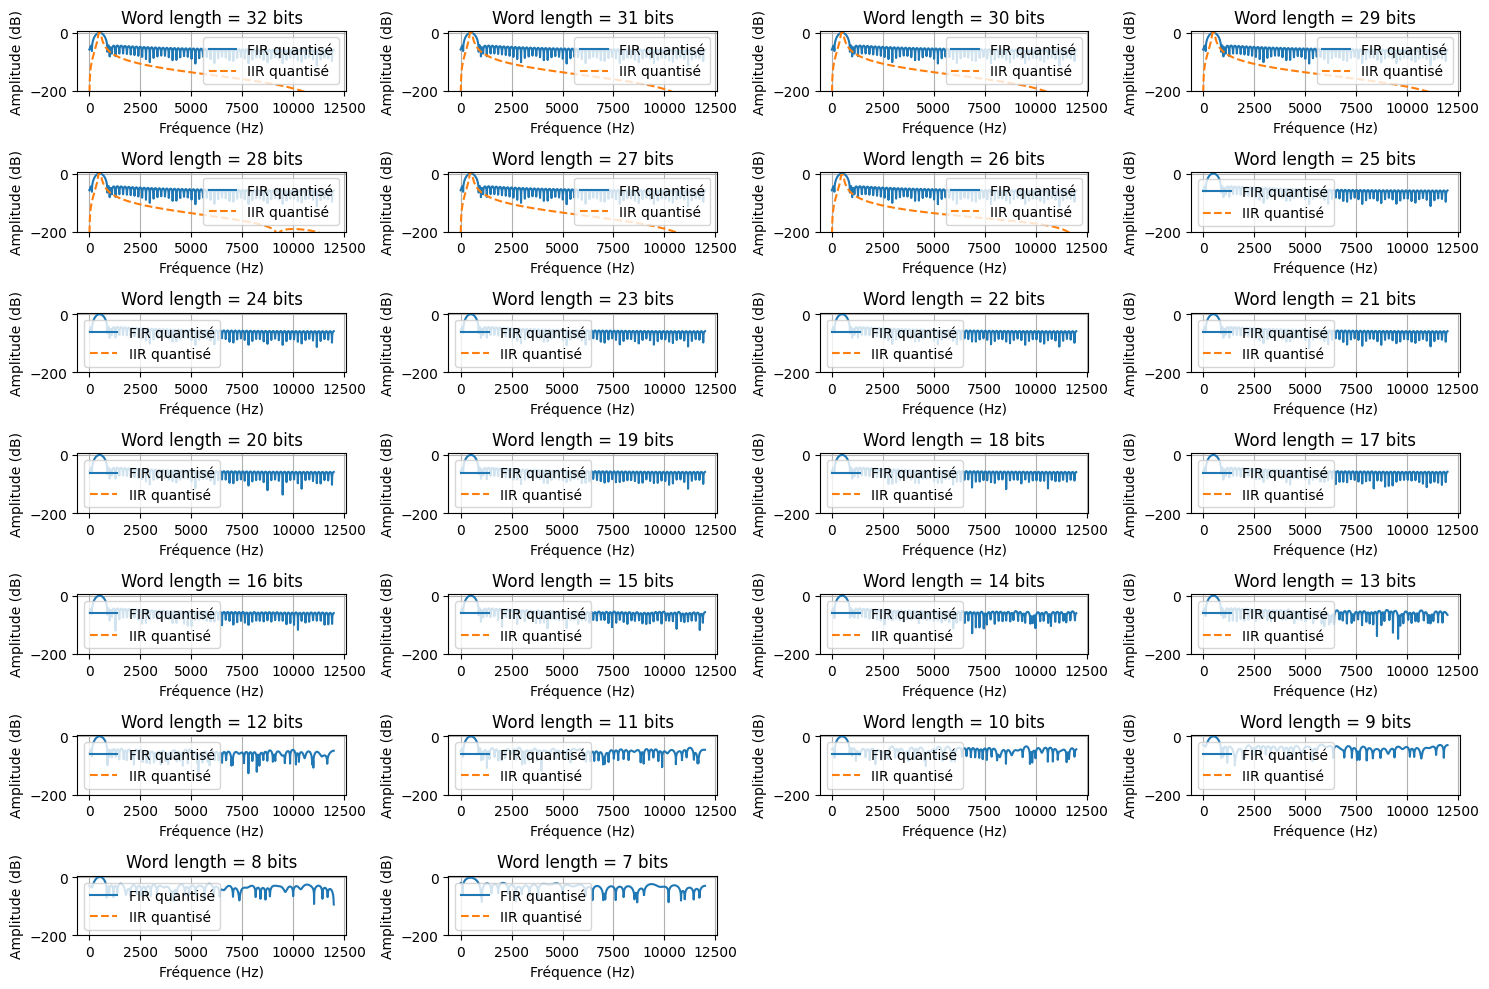

In [ ]:
word_lengths = list(range(32, 6, -1))  # 32 à 7 bits

k = 5  # bande 27
taps_original = filters_FIR[k]
sos_original = filters_IIR[k]

plt.figure(figsize=(15, 10))

for i, wl in enumerate(word_lengths):

    # FIR quantifié
    taps_q = quantize(taps_original, wl, integer_bits=1)  # FIR

    # IIR quantifié 
    sos_q = sos_original.copy()

    # b0,b1,b2 : coefficients du numérateur, peuvent dépasser 1, d'où 3 bits entier
    sos_q[:, :3] = quantize(sos_original[:, :3], wl, integer_bits=3)

    # a1,a2 : coefficients du dénominateur, même logique
    sos_q[:, 4:] = quantize(sos_original[:, 4:], wl, integer_bits=3)
    
    # a0 : reste à 1.0 (normalisation des SOS, donc pas besoin de quantifier)
    # Je pense que en pratique il ne faudrait pas le quatifier, car ça fausserait la normalisation
    sos_q[:, 3] = 1.0

    # Réponses freq
    w_fir, h_fir = freqz(taps_q, [1], worN=2048, fs=fs)
    w_iir, h_iir = sosfreqz(sos_q, worN=2048, fs=fs)

    plt.subplot(len(word_lengths)//4 + 1, 4, i+1)
    plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label='FIR quantisé')
    plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label='IIR quantisé')
    plt.title(f'Word length = {wl} bits')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.grid(True)
    plt.ylim([-200, 5])
    plt.legend()

plt.tight_layout()
plt.show()

## Comparaison avant/après quantification

/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:1125: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:1129: RuntimeWarning: invalid value encountered in divide
  b /= b[0]
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Pôles/Zéros IIR - Bande 27 (Original):
  Zéros: [-1.00016393+0.00000000e+00j -0.99999999+1.63915715e-04j
 -0.99999999-1.63915715e-04j -0.9998361 +0.00000000e+00j
  1.00007995+0.00000000e+00j  1.        +7.99543598e-05j
  1.        -7.99543598e-05j  0.99992004+0.00000000e+00j]
  Pôles: [0.98310575+0.14408375j 0.98310575-0.14408375j 0.9879681 +0.11664255j
 0.9879681 -0.11664255j 0.9763711 +0.13370275j 0.9763711 -0.13370275j
 0.97906748+0.12251178j 0.97906748-0.12251178j]
Pôles/Zéros IIR - Bande 27 (Quantifié 16 bits):
  Zéros: []
  Pôles: [0.98309404+0.1443336j  0.98309404-0.1443336j  0.98797769+0.11630744j
 0.98797769-0.11630744j 0.97637924+0.133699j   0.97637924-0.133699j
 0.9790627 +0.12273535j 0.9790627 -0.12273535j]


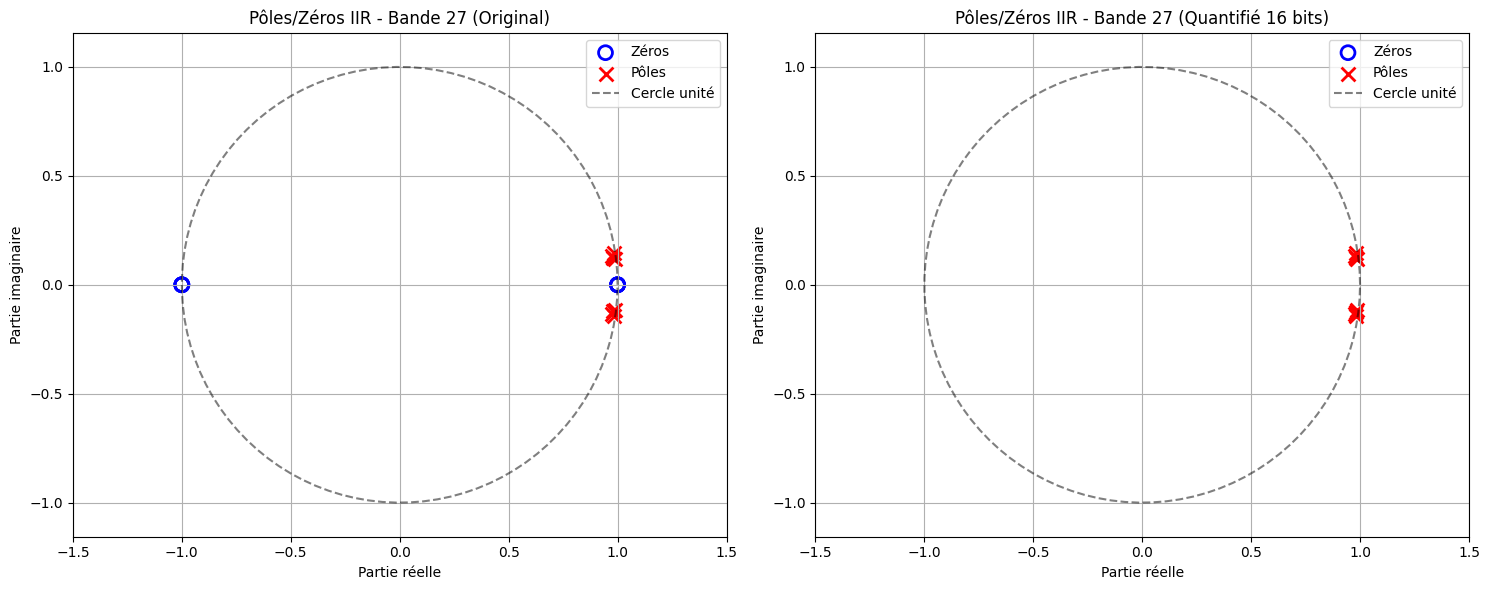

In [ ]:
k = 5  # bande 27
sos_orig = filters_IIR[k]

# Quantification
wl = 16
sos_q = sos_orig.copy()
sos_q[:, :3] = quantize(sos_orig[:, :3], wl, integer_bits=3)
sos_q[:, 4:] = quantize(sos_orig[:, 4:], wl, integer_bits=3)
sos_q[:, 3] = 1.0

# Fonction pour plotter pôles/zéros
def plot_pz(sos, title, subplot_pos):
    # Convertir SOS en fonction de transfert
    b, a = sos2tf(sos)
    z, p, k = tf2zpk(b, a)
    
    print(f"{title}:")
    print(f"  Zéros: {z}")
    print(f"  Pôles: {p}")
    
    plt.subplot(1, 2, subplot_pos)
    plt.scatter(np.real(z), np.imag(z), marker='o', s=100, facecolors='none', edgecolors='b', linewidth=2, label='Zéros')
    plt.scatter(np.real(p), np.imag(p), marker='x', s=100, color='r', linewidth=2, label='Pôles')
    
    # Cercle unité
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5, label='Cercle unité')
    
    plt.axis('equal')
    plt.grid(True)
    plt.title(title)
    plt.xlabel('Partie réelle')
    plt.ylabel('Partie imaginaire')
    plt.legend()
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])

plt.figure(figsize=(15, 6))

# Avant quantification
plot_pz(sos_orig, f'Pôles/Zéros IIR - Bande {bands[k]} (Original)', 1)

# Après quantification
plot_pz(sos_q, f'Pôles/Zéros IIR - Bande {bands[k]} (Quantifié {wl} bits)', 2)

plt.tight_layout()
plt.show()

/tmp/ipykernel_144923/4115449589.py:38: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_orig_iir, 20*np.log10(np.abs(h_orig_iir)), 'b-', label='IIR original', linewidth=2)
/tmp/ipykernel_144923/4115449589.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_q_iir, 20*np.log10(np.abs(h_q_iir)), 'r--', label=f'IIR quantisé {wl} bits', linewidth=2)


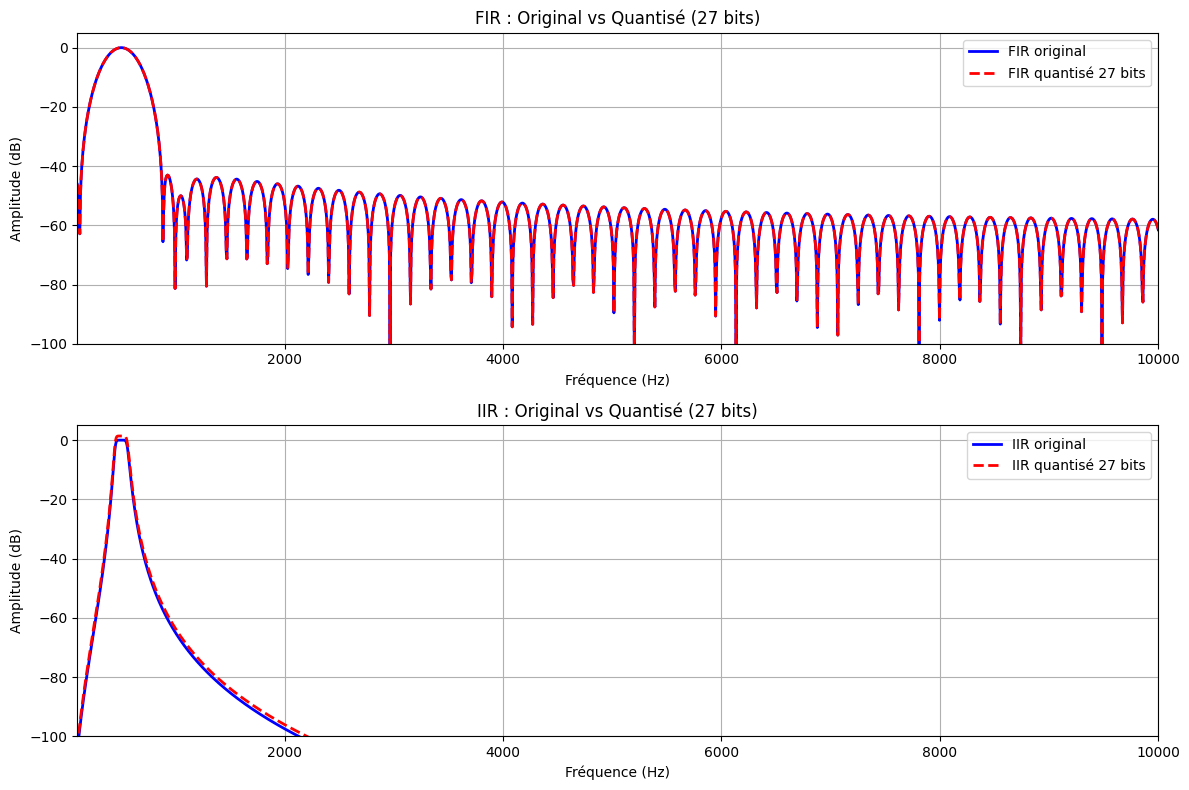

In [31]:
# Comparaison originale vs quantifiée
wl = 27
k = 5  # bande 27

taps_orig = filters_FIR[k]
sos_orig = filters_IIR[k]

# Quantifiés
taps_q = quantize(taps_orig, wl, integer_bits=1)
sos_q = sos_orig.copy()
sos_q[:, :3] = quantize(sos_orig[:, :3], wl, integer_bits=3)
sos_q[:, 4:] = quantize(sos_orig[:, 4:], wl, integer_bits=3)
sos_q[:, 3] = 1.0

# Réponses

w_orig_fir, h_orig_fir = freqz(taps_orig, [1], worN=2048, fs=fs)
w_orig_iir, h_orig_iir = sosfreqz(sos_orig, worN=2048, fs=fs)
w_q_fir, h_q_fir = freqz(taps_q, [1], worN=2048, fs=fs)
w_q_iir, h_q_iir = sosfreqz(sos_q, worN=2048, fs=fs)

plt.figure(figsize=(12, 8))

# FIR
plt.subplot(2, 1, 1)
plt.plot(w_orig_fir, 20*np.log10(np.abs(h_orig_fir)), 'b-', label='FIR original', linewidth=2)
plt.plot(w_q_fir, 20*np.log10(np.abs(h_q_fir)), 'r--', label=f'FIR quantisé {wl} bits', linewidth=2)
plt.title(f'FIR : Original vs Quantisé ({wl} bits)')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.ylim([-100, 5])
plt.legend()
plt.xlim([100, 10000])  # zoom sur les fréquences utiles

# IIR
plt.subplot(2, 1, 2)
plt.plot(w_orig_iir, 20*np.log10(np.abs(h_orig_iir)), 'b-', label='IIR original', linewidth=2)
plt.plot(w_q_iir, 20*np.log10(np.abs(h_q_iir)), 'r--', label=f'IIR quantisé {wl} bits', linewidth=2)
plt.title(f'IIR : Original vs Quantisé ({wl} bits)')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.ylim([-100, 5])
plt.legend()
plt.xlim([100, 10000])

plt.tight_layout()
plt.show()

In [32]:
print("\n=== Exemple quantif FIR / IIR pour WL = 8 bits ===")
print("Taps FIR orig :", taps_original[:5])
print("Taps FIR q8   :", quantize(taps_original, 8, integer_bits=1)[:5])

print("\nSOS orig :\n", sos_original)
sos_q8 = sos_original.copy()

# Petit rapelle ;') 
# sos_original[:, :3] veut dire toutes les lignes, mais seulement les 3 premières colonnes donc b0, b1, b2
sos_q8[:, :3] = quantize(sos_original[:, :3], 8, integer_bits=3)
sos_q8[:, 4:] = quantize(sos_original[:, 4:], 8, integer_bits=3)
sos_q8[:, 3] = 1.0
print("\nSOS q8 :\n", sos_q8)


=== Exemple quantif FIR / IIR pour WL = 8 bits ===
Taps FIR orig : [-0.00111086 -0.00088893 -0.00065454 -0.00040081 -0.00012054]
Taps FIR q8   : [-0. -0. -0. -0. -0.]

SOS orig :
 [[ 5.07278137e-08  1.01455627e-07  5.07278137e-08  1.00000000e+00
  -1.95274233e+00  9.71176329e-01]
 [ 1.00000000e+00  2.00000000e+00  1.00000000e+00  1.00000000e+00
  -1.95813991e+00  9.73587760e-01]
 [ 1.00000000e+00 -2.00000000e+00  1.00000000e+00  1.00000000e+00
  -1.96620991e+00  9.87255630e-01]
 [ 1.00000000e+00 -2.00000000e+00  1.00000000e+00  1.00000000e+00
  -1.97593271e+00  9.89682908e-01]]

SOS q8 :
 [[ 0.       0.       0.       1.      -1.9375   0.96875]
 [ 1.       2.       1.       1.      -1.96875  0.96875]
 [ 1.      -2.       1.       1.      -1.96875  1.     ]
 [ 1.      -2.       1.       1.      -1.96875  1.     ]]


## Interprétation

ICI, chaque ligne du tableau SOS correspond à une section IIR d’ordre 2.  
Le filtre complet est obtenu en mettant toutes ces sections **en cascade**.

Un SOS est toujours de la forme :

[b0  b1  b2   a0  a1  a2] avec **a0 = 1** (normalisation standard).

Les filtres 1/3-octave ANSI S1.11 sont très étroits : leurs pôles sont
proches du cercle unité, donc une très petite erreur sur a1 ou a2 peut
modifier fortement la réponse ou rendre le filtre instable.

À l’inverse, les FIR n’ont **pas de rétroaction**, sont toujours stables et
supportent beaucoup mieux la quantification fixe.


## Verification standard + guess ordre du filtre

In [33]:
def verify_ansi_standard(taps, fl, fu, fs, delta_rel=0.05):
    """
    Vérifie si un filtre FIR de bande 1/3-octave respecte le standard
    ANSI S1.11 (classe 2), avec une marge relative
    Args:
    
        taps : array coefficients du filtre FIR
        fl : float fréquence de coupure basse de la bande utile (en Hz)
        fu : float fréquence de coupure haute de la bande utile (en Hz)
        fs : float fréquence d'échantillonnage du système (en Hz)
        delta_rel : float, optionnel marge relative en dB (facteur multiplicatif)

    Returns:
        dict
            {
                "ripple_db"         : ripple dans la bande passante (dB),
                "att_low_db"        : atténuation dans la bande d'arrêt basse (dB),
                "att_high_db"       : atténuation dans la bande d'arrêt haute (dB),
                "valid"             : True si le filtre respecte le standard (avec marge delta),
                "spec_ripple_max"   : limite max du ripple (avec marge),
                "spec_atten_min"    : limite min de l'atténuation (avec marge)
            }
    """
    
    # Spécification AINSI S1.11 classe 2
    ripple_max = 1.0 # + ou - 1 dB
    atten_min  = 60.0 # 60 dB stopband
    
    # On applique la marge relative
    ripple_max *= (1 + delta_rel)
    atten_min  *= (1 - delta_rel)
    

    w, h = freqz(taps, worN=4096, fs=fs)

    # + epsilon pour éviter log(0)
    H = 20 * np.log10(np.abs(h) + 1e-12)

    # Définition des zones de fréquence selon ANSI S1.11:
    # - passband: entre fl et fu
    # - stopband basse: en dessous de fl / 2^(1/6)
    # - stopband haute: au-dessus de fu * 2^(1/6)
    passband = (w >= fl) & (w <= fu)
    stop_lo  = w <  fl / (2 ** (1/6))
    stop_hi  = w >  fu * (2 ** (1/6))

    # En réalité, dans la bande passante le gain du filtre n'est pas parfaitement plat,
    # il y a des variations (ondulations) appelées "ripple"
    # Pour évaluer la performance du filtre, on calcule le ripple comme la
    # différence max-min de l'amplitude en dB dans la passband
    ripple = H[passband].max() - H[passband].min()

    # Atténuation dans les bandes d'arrêt : on prend la valeur la "moins atténuée"
    # (c'est-à-dire la plus proche de 0 dB, donc la pire performance)
    att_lo = -H[stop_lo].max()
    att_hi = -H[stop_hi].max()

    # Vérifications ANSI
    ripple_ok  = ripple <= ripple_max
    stop_lo_ok = att_lo >= atten_min
    stop_hi_ok = att_hi >= atten_min

    return {
        "ripple_db": ripple,
        "att_low_db": att_lo,
        "att_high_db": att_hi,
        "valid": ripple_ok and stop_lo_ok and stop_hi_ok,
        "spec_ripple_max": ripple_max,
        "spec_atten_min": atten_min
    }

In [34]:
def guess_fir_order(fl, fu, fs, delta_rel=0.05, max_order=200000):
    """
    Recherche dichotomique du plus petit ordre FIR qui respecte ANSI S1.11
    
    Note : Scipy n’a pas d’équivalent de 'filterorder' MATLAB pour FIR
    
    Args:
        fl, fu, fs : fréquences et échantillonnage (en Hz)
        delta_rel : marge relative en dB
        max_order : ordre max à tester (évite boucle infinie)
    
    Returns:
        int : ordre minimal FIR, ou None si pas trouvé dans max_order
    """
    
    # Recherche binaire : on teste des ordres de plus en plus petits/grands
    # pour trouver le plus petit ordre qui satisfait les specs ANSI
    low = 1  # ordre min
    high = max_order  # ordre max
    best = None  # meilleur ordre trouvé (initialement None)
    
    while low <= high:
        mid = (low + high) // 2  # ordre milieu à tester
        
        # Crée un filtre FIR d'ordre mid-1 (numtaps = ordre + 1 car normalement numtaps = ordre + 1)
        taps = firwin(
            numtaps=mid,
            cutoff=[fl/(fs/2), fu/(fs/2)],
            pass_zero=False
        )
        
        # Vérifie si ce filtre respecte ANSI avec la marge delta (relative)
        result = verify_ansi_standard(taps, fl, fu, fs, delta_rel)
        
        if result["valid"]:
            # Filtre valide : on peut essayer plus petit (chercher min)
            best = mid
            high = mid - 1
        else:
            # Pas valide : besoin d'ordre plus élevé
            low = mid + 1
    
    return best

In [35]:
def guess_iir_order(fl, fu, fs):
    """
    Utilise directement buttord pour obtenir l'ordre minimal IIR Butterworth (fonction scipy)
    
    Args:
        fl, fu, fs : fréquences et échantillonnage (en Hz)
    
    Returns:
        int : ordre minimal IIR Butterworth pour respecter ripple <1dB et atténuation >60dB
    """
    
    # Définition des bandes passante et d'arrêt avec marges pour la stabilité (en faite sinon la juste en testant j'ai -2000000 ;'))
    # Passband légèrement élargie (fl*1.05, fu*0.95) pour garantir le ripple
    # Stopband légèrement rétrécie (fl*0.95, fu*1.05) pour l'atténuation
    wp = [fl*1.05, fu*0.95]
    ws = [fl*0.95, fu*1.05]

    # Normalisation des fréquences car buttord attend aussi des valeurs entre 0 et 1
    wp = np.array(wp) / (fs/2)
    ws = np.array(ws) / (fs/2)

    gpass = 1     # ripple < 1 dB
    gstop = 60    # atténuation > 60 dB

    N, Wn = buttord(wp, ws, gpass, gstop)
    return N

In [36]:
fl, f0, fu = ansi_band(27)

fir_order = guess_fir_order(fl, fu, fs, delta_rel=0.05)
iir_order = guess_iir_order(fl, fu, fs)

print(f"Ordre FIR trouvé : {fir_order}")
print(f"Ordre IIR trouvé : {iir_order}")

Ordre FIR trouvé : 12498
Ordre IIR trouvé : 9


# Interpretation

Pas sûr mais, la raison la plus probable est que les filtres 1/3 octave sont très sélectifs (bandes étroites), donc avec ordre 4 (arbitraire que on a utilisé), le filtre ne respecte peut-être pas parfaitement les specs ANSI